# POC: CPU Inference on Test Tiles (No Tiling)

This notebook is a minimal, readable proof-of-concept to run one ONNX inference pass on the local test tile pair.

 
## Scope
- CPU only (`CPUExecutionProvider`)
- No tiling/windowing, no batching beyond `batch=1`
- Keep the notebook skinny and explicit
        


In [1]:
# Configure deterministic project-local paths before running any other cell.
from pathlib import Path
import os

PROJECT_ROOT = Path("/workspace").resolve()
os.chdir(PROJECT_ROOT)
root = Path.cwd()

# Keep all paths explicit for readability.
model_fp = Path("_inputs/ResUNet_16x_DEM/model_infer.onnx")
tile_dir = Path("tests/data/2407_FHIMP_tile")
lowres_fp = tile_dir / "lowres032.tif"
hires_fp = tile_dir / "hires002.tif"
dem_fp = tile_dir / "hires002_dem.tif"

# Assert the key files exist before doing work.
assert model_fp.exists(), f"missing model file: {model_fp}"
assert lowres_fp.exists(), f"missing low-res depth tile: {lowres_fp}"
assert hires_fp.exists(), f"missing hi-res depth tile: {hires_fp}"
assert dem_fp.exists(), f"missing hi-res DEM tile: {dem_fp}"

print(f"cwd: {Path.cwd()}")
print("Using files:")
print(f"  model:  {model_fp}")
print(f"  lowres: {lowres_fp}")
print(f"  hires:  {hires_fp}")
print(f"  dem:    {dem_fp}")


cwd: /workspace
Using files:
  model:  _inputs/ResUNet_16x_DEM/model_infer.onnx
  lowres: tests/data/2407_FHIMP_tile/lowres032.tif
  hires:  tests/data/2407_FHIMP_tile/hires002.tif
  dem:    tests/data/2407_FHIMP_tile/hires002_dem.tif


## 1) Setup and Paths
        


In [2]:
# Major imports for this notebook.
from pathlib import Path
from typing import Dict, Optional, Tuple
import importlib.metadata as md
import json

import matplotlib.pyplot as plt
import numpy as np
import onnx
from PIL import Image
import rasterio


## 2) Environment Probe (Package Versions)

This keeps API/debug context tied to the current environment.
        


In [3]:
# Report versions of the core packages used in this notebook.
for pkg_name in ["numpy", "rasterio", "onnx", "onnxruntime", "pillow"]:
    try:
        print(f"{pkg_name}: {md.version(pkg_name)}")
    except md.PackageNotFoundError:
        print(f"{pkg_name}: MISSING (install in this environment)")

# python location and version
import sys
print(f"Python executable: {sys.executable} (version {sys.version})")


numpy: 2.4.2
rasterio: 1.5.0
onnx: 1.18.0
onnxruntime: 1.24.1
pillow: 12.1.1
Python executable: /usr/local/bin/python (version 3.12.12 (main, Jan 13 2026, 06:06:33) [GCC 12.2.0])


## helpers

In [4]:
# Inline helper copied from t02.tools_train: validate numeric arrays and rank constraints.
def _as_numeric_np_array(
    arr: np.ndarray,
    name: str,
    min_rank: int = 1,
    allow_ranks: Optional[Tuple[int, ...]] = None,
    require_single_channel_last_dim: bool = False,
) -> np.ndarray:
    """Convert input to NumPy array and validate dtype/rank constraints."""
    out = np.asarray(arr)
    if out.dtype == np.bool_ or not np.issubdtype(out.dtype, np.number):
        raise AssertionError(f"{name} must have numeric dtype; got {out.dtype}")

    rank = int(out.ndim)
    if allow_ranks is not None:
        if rank not in allow_ranks:
            raise AssertionError(f"{name} rank must be one of {allow_ranks}; got rank {rank} shape {out.shape}")
    elif rank < min_rank:
        raise AssertionError(f"{name} rank must be >= {min_rank}; got rank {rank} shape {out.shape}")

    if require_single_channel_last_dim and rank >= 3 and out.shape[-1] != 1:
        raise AssertionError(f"{name} last dim must be 1 for rank >=3; got shape {out.shape}")

    if not np.all(np.isfinite(out)):
        raise AssertionError(f"{name} must contain only finite values")
    return out


# Inline helper copied from t02.tools_train: validate persisted DEM normalization stats.
def _parse_dem_normalization_stats(ref_stats: Dict[str, float]) -> Tuple[float, float, float]:
    """Validate and unpack DEM normalization stats dictionary."""
    required = {"p_clip", "dem_min", "dem_max"}
    missing = required.difference(ref_stats.keys())
    if missing:
        raise AssertionError(f"DEM ref_stats missing keys: {sorted(missing)}")

    p_clip = float(ref_stats["p_clip"])
    dem_min = float(ref_stats["dem_min"])
    dem_max = float(ref_stats["dem_max"])

    if not (np.isfinite(p_clip) and np.isfinite(dem_min) and np.isfinite(dem_max)):
        raise AssertionError("DEM ref_stats values must be finite")
    if p_clip < 0:
        raise AssertionError(f"DEM p_clip must be >= 0; got {p_clip}")
    if dem_min > dem_max:
        raise AssertionError(f"DEM dem_min must be <= dem_max; got min={dem_min} max={dem_max}")
    if (dem_max - dem_min) <= 0:
        raise AssertionError(f"DEM range must be > 0; got min={dem_min}, max={dem_max}")
    return p_clip, dem_min, dem_max


# Inline helper copied from t02.tools_train: apply DEM normalization with fixed clip/min/max.
def _normalize_dem_with_stats_np(
    arr: np.ndarray,
    p_clip: float,
    dem_min: float,
    dem_max: float,
) -> np.ndarray:
    """Normalize DEM with already-computed clip/min/max stats."""
    if not (np.isfinite(p_clip) and np.isfinite(dem_min) and np.isfinite(dem_max)):
        raise AssertionError("p_clip, dem_min, and dem_max must be finite")

    dem_range = dem_max - dem_min
    if dem_range <= 0:
        raise AssertionError(f"DEM range must be > 0; got min={dem_min}, max={dem_max}")

    arr_np = _as_numeric_np_array(
        arr,
        "dem_arr",
        allow_ranks=(2, 3, 4),
        require_single_channel_last_dim=True,
    ).astype(np.float32, copy=False)

    arr_clipped = np.clip(arr_np, 0.0, float(p_clip))
    arr_norm = (arr_clipped - float(dem_min)) / float(dem_range)
    arr_norm = np.clip(arr_norm, 0.0, 1.0)
    return arr_norm.astype(np.float32, copy=False)


# Inline helper copied from t02.tools_train: stable denominator for depth log scaling.
def _depth_log1p_denom(max_depth: float) -> float:
    """Compute and validate denominator used by depth log1p scaling."""
    max_depth = float(max_depth)
    if not np.isfinite(max_depth) or max_depth <= 0:
        raise AssertionError(f"max_depth must be finite and > 0; got {max_depth}")

    denom = float(np.log1p(max_depth))
    if not np.isfinite(denom) or denom <= 0:
        raise AssertionError(f"log1p(max_depth) must be finite and > 0; got {denom}")
    return denom


# Inline helper copied from t02.tools_train: forward depth scaling to normalized log-space.
def _scale_depth_log1p_np(arr: Optional[np.ndarray], max_depth: float) -> Optional[np.ndarray]:
    """Clip depth values and apply log1p normalization."""
    if arr is None:
        return None

    denom = _depth_log1p_denom(max_depth)
    arr_np = _as_numeric_np_array(arr, "depth_arr", min_rank=1).astype(np.float32, copy=False)
    arr_np = np.clip(arr_np, 0.0, float(max_depth))
    scaled = np.log1p(arr_np) / denom
    scaled = np.clip(scaled, 0.0, 1.0)
    return scaled.astype(np.float32, copy=False)


# Inline helper copied from t02.tools_train: inverse depth scaling back to meters.
def _invert_depth_log1p_np(arr: Optional[np.ndarray], max_depth: float) -> Optional[np.ndarray]:
    """Invert normalized log1p depth values back to depth units."""
    if arr is None:
        return None

    denom = _depth_log1p_denom(max_depth)
    arr_np = _as_numeric_np_array(arr, "normalized_depth_arr", min_rank=1).astype(np.float32, copy=False)
    arr_np = np.clip(arr_np, 0.0, 1.0)
    inv = np.expm1(arr_np * denom)
    inv = np.clip(inv, 0.0, float(max_depth))
    return inv.astype(np.float32, copy=False)


# Inline helper copied from t02.tools_train: DEM clipping + min-max normalization.
def _normalize_dem(
    arr: Optional[np.ndarray],
    pct_clip: float = 95.0,
    ref_stats: Optional[Dict[str, float]] = None,
) -> Tuple[Optional[np.ndarray], Optional[Dict[str, float]]]:
    """Clip DEM and min-max normalize to [0,1]."""
    if arr is None:
        return None, None

    if ref_stats is None:
        pct_clip = float(pct_clip)
        if not np.isfinite(pct_clip) or not (0 < pct_clip <= 100):
            raise AssertionError(f"dem_pct_clip must be finite and in (0, 100]; got {pct_clip}")

        arr_np = _as_numeric_np_array(
            arr,
            "dem_arr",
            allow_ranks=(2, 3, 4),
            require_single_channel_last_dim=True,
        ).astype(np.float32, copy=False)
        arr_np = np.clip(arr_np, 0.0, None)
        p_clip = float(np.nanpercentile(arr_np, pct_clip))
        arr_for_stats = np.clip(arr_np, 0.0, p_clip)
        dem_min = float(np.nanmin(arr_for_stats))
        dem_max = float(np.nanmax(arr_for_stats))
    else:
        p_clip, dem_min, dem_max = _parse_dem_normalization_stats(ref_stats)

    arr_norm = _normalize_dem_with_stats_np(arr, p_clip=p_clip, dem_min=dem_min, dem_max=dem_max)
    return arr_norm, {"p_clip": p_clip, "dem_min": dem_min, "dem_max": dem_max}


# Inline helper copied from t02.results: compact stats annotation for histogram panels.
def _stats_text(values: np.ndarray) -> str:
    """Format summary stats for 1D value arrays."""
    if values.size == 0:
        return "n=0"
    return (
        f"n={values.size}\n"
        f"min={values.min():.4f}\n"
        f"mean={values.mean():.4f}\n"
        f"max={values.max():.4f}\n"
        f"std={values.std():.4f}"
    )


## 3) Probe the ONNX Weights File

This cell inspects graph metadata, opset, and I/O tensor shapes.
        


In [5]:
# Load ONNX model metadata and print a compact graph summary.
onnx_model = onnx.load(model_fp.as_posix())
print(f"model size (MB): {model_fp.stat().st_size / 1e6:.2f}")
print(f"producer: {onnx_model.producer_name} {onnx_model.producer_version}")
print(f"IR version: {onnx_model.ir_version}")
print("opsets:")
for opset in onnx_model.opset_import:
    domain = opset.domain if opset.domain else "ai.onnx"
    print(f"  - {domain}: {opset.version}")


initializer_param_count = int(sum(int(np.prod(t.dims)) for t in onnx_model.graph.initializer))
print(f"parameter count: {initializer_param_count:,}")

def _tensor_dims(tensor):
    dims = []
    for dim in tensor.type.tensor_type.shape.dim:
        if dim.dim_param:
            dims.append(dim.dim_param)
        elif dim.dim_value:
            dims.append(int(dim.dim_value))
        else:
            dims.append("?")
    return dims


graph_input_d = {}
graph_output_d = {}
print("\ninputs:")
for tensor in onnx_model.graph.input:
    dims = _tensor_dims(tensor)
    graph_input_d[tensor.name] = dims
    print(f"  - {tensor.name}: dtype={tensor.type.tensor_type.elem_type}, shape={dims}")

print("\noutputs:")
for tensor in onnx_model.graph.output:
    dims = _tensor_dims(tensor)
    graph_output_d[tensor.name] = dims
    print(f"  - {tensor.name}: dtype={tensor.type.tensor_type.elem_type}, shape={dims}")


def _resolve_hwc(dims, tensor_name):
    assert len(dims) == 4, f"{tensor_name} must be rank-4 NHWC; got {dims}"
    h, w, c = dims[1], dims[2], dims[3]
    assert isinstance(h, int) and h > 0, f"{tensor_name} height must be fixed int; got {h}"
    assert isinstance(w, int) and w > 0, f"{tensor_name} width must be fixed int; got {w}"
    assert isinstance(c, int) and c == 1, f"{tensor_name} channels must be 1; got {c}"
    return (h, w, c)


assert "depth_lr" in graph_input_d, "model input 'depth_lr' not found"
assert "dem_hr" in graph_input_d, "model input 'dem_hr' not found"
assert len(graph_output_d) > 0, "model outputs are empty"

lr_hwc = _resolve_hwc(graph_input_d["depth_lr"], "depth_lr")
hr_hwc = _resolve_hwc(graph_input_d["dem_hr"], "dem_hr")
first_output_name = next(iter(graph_output_d))
out_hwc = _resolve_hwc(graph_output_d[first_output_name], first_output_name)

assert hr_hwc == out_hwc, f"DEM input shape {hr_hwc} != output shape {out_hwc}"
assert lr_hwc[0] == lr_hwc[1], f"LR input must be square for this POC; got {lr_hwc}"
assert hr_hwc[0] == hr_hwc[1], f"HR input must be square for this POC; got {hr_hwc}"
assert hr_hwc[0] % lr_hwc[0] == 0, f"HR/LR height ratio must be integer; got HR={hr_hwc}, LR={lr_hwc}"

scale = hr_hwc[0] // lr_hwc[0]
lr_tile = lr_hwc[0]
hr_tile = hr_hwc[0]


model size (MB): 24.11
producer: tf2onnx 1.8.4
IR version: 7
opsets:
  - ai.onnx: 13
parameter count: 12,045,568

inputs:
  - depth_lr: dtype=1, shape=['unk__300', 32, 32, 1]
  - dem_hr: dtype=1, shape=['unk__301', 512, 512, 1]

outputs:
  - depth_hr_pred: dtype=1, shape=['unk__302', 512, 512, 1]


In [6]:

# Resolve preprocessing constants from training metadata when available.
max_depth = 5.0
dem_pct_clip = 95.0
dem_ref_stats = None

train_config_fp = model_fp.parent / "train_config.json"
if train_config_fp.exists():
    train_cfg = json.loads(train_config_fp.read_text())

    if train_cfg.get("max_depth") is not None:
        max_depth = float(train_cfg["max_depth"])
    if train_cfg.get("dem_pct_clip") is not None:
        dem_pct_clip = float(train_cfg["dem_pct_clip"])

    cfg_input_shape = train_cfg.get("input_shape")
    if cfg_input_shape and len(cfg_input_shape) >= 3:
        cfg_lr_hwc = tuple(int(v) for v in cfg_input_shape[:3])
        assert cfg_lr_hwc == lr_hwc, f"train_config input_shape {cfg_lr_hwc} != ONNX LR shape {lr_hwc}"

    cfg_dem_shape = train_cfg.get("dem_shape")
    if cfg_dem_shape and len(cfg_dem_shape) >= 3:
        cfg_hr_hwc = tuple(int(v) for v in cfg_dem_shape[:3])
        assert cfg_hr_hwc == hr_hwc, f"train_config dem_shape {cfg_hr_hwc} != ONNX HR shape {hr_hwc}"

    cfg_upscale = train_cfg.get("upscale")
    if cfg_upscale is not None:
        assert int(cfg_upscale) == scale, f"train_config upscale {cfg_upscale} != inferred scale {scale}"

    dem_stats_cfg = train_cfg.get("dem_stats") or {}
    required_keys = {"p_clip", "dem_min", "dem_max"}
    if required_keys.issubset(dem_stats_cfg):
        dem_ref_stats = {k: float(dem_stats_cfg[k]) for k in sorted(required_keys)}

    print(f"Loaded train config from {train_config_fp}")
else:
    print(f"train_config.json not found at {train_config_fp}; using notebook defaults.")

assert scale > 0, f"scale must be > 0; got {scale}"
assert max_depth > 0, f"max_depth must be > 0; got {max_depth}"
assert 0 < dem_pct_clip <= 100, f"dem_pct_clip must be in (0, 100]; got {dem_pct_clip}"

print(f"Resolved geometry: SCALE={scale}, LR_TILE={lr_tile}, HR_TILE={hr_tile}")
print(f"Resolved preprocessing: MAX_DEPTH={max_depth}, DEM_PCT_CLIP={dem_pct_clip}")
if dem_ref_stats is not None:
    print(f"Using train DEM stats: {dem_ref_stats}")
    


Loaded train config from _inputs/ResUNet_16x_DEM/train_config.json
Resolved geometry: SCALE=16, LR_TILE=32, HR_TILE=512
Resolved preprocessing: MAX_DEPTH=5.0, DEM_PCT_CLIP=95.0


## 4) Load Test Tiles (Single Pair)

No windowing or tiling logic is used here; each raster is read once in full.
        


In [7]:
# Read low-res depth tile and keep metadata useful for diagnostics.
with rasterio.open(lowres_fp) as ds:
    depth_lr_raw = ds.read(1).astype(np.float32)
    depth_lr_nodata = ds.nodata
    depth_lr_profile = ds.profile.copy()
    depth_lr_res = ds.res

# Read hi-res depth tile for visual comparison against prediction.
with rasterio.open(hires_fp) as ds:
    depth_hr_true_raw = ds.read(1).astype(np.float32)
    depth_hr_true_nodata = ds.nodata
    depth_hr_true_profile = ds.profile.copy()
    depth_hr_true_res = ds.res

# Read DEM hi-res tile and keep metadata useful for preprocessing diagnostics.
with rasterio.open(dem_fp) as ds:
    dem_hr_raw = ds.read(1).astype(np.float32)
    dem_hr_nodata = ds.nodata
    dem_hr_profile = ds.profile.copy()
    dem_hr_res = ds.res

print(
    f"depth_lr shape={depth_lr_raw.shape}, dtype={depth_lr_raw.dtype}, "
    f"nodata={depth_lr_nodata}, res={depth_lr_res}"
)
print(
    f"depth_hr shape={depth_hr_true_raw.shape}, dtype={depth_hr_true_raw.dtype}, "
    f"nodata={depth_hr_true_nodata}, res={depth_hr_true_res}"
)
print(
    f"dem_hr   shape={dem_hr_raw.shape}, dtype={dem_hr_raw.dtype}, "
    f"nodata={dem_hr_nodata}, res={dem_hr_res}"
)

# Replace nodata with 0.0 before normalization for this proof-of-concept.
if depth_lr_nodata is not None:
    depth_lr_raw = np.where(np.isclose(depth_lr_raw, depth_lr_nodata), 0.0, depth_lr_raw)
if depth_hr_true_nodata is not None:
    depth_hr_true_raw = np.where(np.isclose(depth_hr_true_raw, depth_hr_true_nodata), 0.0, depth_hr_true_raw)
if dem_hr_nodata is not None:
    dem_hr_raw = np.where(np.isclose(dem_hr_raw, dem_hr_nodata), 0.0, dem_hr_raw)

assert np.isfinite(depth_lr_raw).all(), "low-res depth tile contains non-finite values after nodata replacement"
assert np.isfinite(depth_hr_true_raw).all(), "hi-res depth tile contains non-finite values after nodata replacement"
assert np.isfinite(dem_hr_raw).all(), "DEM tile contains non-finite values after nodata replacement"

# Validate expected HR/LR relationship against model geometry.
shape_scale_h = dem_hr_raw.shape[0] / depth_lr_raw.shape[0]
shape_scale_w = dem_hr_raw.shape[1] / depth_lr_raw.shape[1]
res_scale_x = abs(depth_lr_res[0]) / abs(dem_hr_res[0])
res_scale_y = abs(depth_lr_res[1]) / abs(dem_hr_res[1])

print(
    f"Input-derived scale: shape=({shape_scale_h:.2f}, {shape_scale_w:.2f}), "
    f"resolution=({res_scale_x:.2f}, {res_scale_y:.2f})"
)

assert depth_hr_true_raw.shape == dem_hr_raw.shape, (
    f"hi-res depth shape {depth_hr_true_raw.shape} must match DEM shape {dem_hr_raw.shape}"
)
assert np.isclose(abs(depth_hr_true_res[0]), abs(dem_hr_res[0])), (
    f"hi-res depth x-res {depth_hr_true_res[0]} must match DEM x-res {dem_hr_res[0]}"
)
assert np.isclose(abs(depth_hr_true_res[1]), abs(dem_hr_res[1])), (
    f"hi-res depth y-res {depth_hr_true_res[1]} must match DEM y-res {dem_hr_res[1]}"
)

assert np.isclose(shape_scale_h, scale), f"DEM/LR shape scale {shape_scale_h} != model scale {scale}"
assert np.isclose(shape_scale_w, scale), f"DEM/LR shape scale {shape_scale_w} != model scale {scale}"
assert np.isclose(res_scale_x, scale), f"DEM/LR x-res scale {res_scale_x} != model scale {scale}"
assert np.isclose(res_scale_y, scale), f"DEM/LR y-res scale {res_scale_y} != model scale {scale}"

# Match training preprocessing before ONNX inference.
depth_lr_norm = _scale_depth_log1p_np(depth_lr_raw, max_depth=max_depth)
dem_hr_norm, dem_stats = _normalize_dem(dem_hr_raw, pct_clip=dem_pct_clip, ref_stats=dem_ref_stats)
assert dem_stats is not None, "DEM normalization did not return stats"

print(f"depth_lr_norm min={depth_lr_norm.min():.4f}, max={depth_lr_norm.max():.4f}")
print(f"dem_hr_norm   min={dem_hr_norm.min():.4f}, max={dem_hr_norm.max():.4f}")
print(f"dem stats used: {dem_stats}")

# Convert rasters to batched NHWC tensors expected by this ONNX model.
depth_lr_nhwc = depth_lr_norm[np.newaxis, :, :, np.newaxis].astype(np.float32)
dem_hr_nhwc = dem_hr_norm[np.newaxis, :, :, np.newaxis].astype(np.float32)

assert depth_lr_nhwc.shape[1:] == lr_hwc, f"depth tensor shape {depth_lr_nhwc.shape[1:]} != expected {lr_hwc}"
assert dem_hr_nhwc.shape[1:] == hr_hwc, f"DEM tensor shape {dem_hr_nhwc.shape[1:]} != expected {hr_hwc}"
assert 0.0 <= float(depth_lr_nhwc.min()) <= 1.0 and float(depth_lr_nhwc.max()) <= 1.0, "depth tensor out of [0,1]"
assert 0.0 <= float(dem_hr_nhwc.min()) <= 1.0 and float(dem_hr_nhwc.max()) <= 1.0, "DEM tensor out of [0,1]"


depth_lr shape=(32, 32), dtype=float32, nodata=-9999.0, res=(32.0, 32.0)
depth_hr shape=(512, 512), dtype=float32, nodata=-9999.0, res=(2.0, 2.0)
dem_hr   shape=(512, 512), dtype=float32, nodata=-9999.0, res=(2.0, 2.0)
Input-derived scale: shape=(16.00, 16.00), resolution=(16.00, 16.00)
depth_lr_norm min=0.0000, max=0.7143
dem_hr_norm   min=0.0000, max=1.0000
dem stats used: {'p_clip': 1090.342041015625, 'dem_min': 1073.68896484375, 'dem_max': 1090.342041015625}


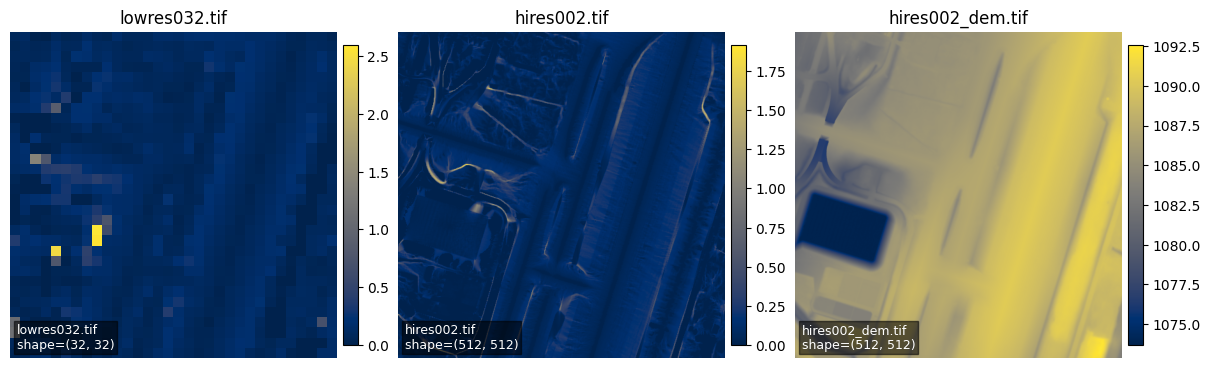

In [8]:
# Quick side-by-side preview of loaded rasters with shape and filename labels.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True)

preview_items = [
    (lowres_fp.name, depth_lr_raw),
    (hires_fp.name, depth_hr_true_raw),
    (dem_fp.name, dem_hr_raw),
]

for ax, (file_name, arr) in zip(axes, preview_items):
    im = ax.imshow(arr, cmap="cividis")
    ax.set_axis_off()
    ax.set_title(file_name)
    ax.text(
        0.02,
        0.02,
        f"{file_name}\nshape={arr.shape}",
        transform=ax.transAxes,
        ha="left",
        va="bottom",
        fontsize=9,
        color="white",
        bbox={"facecolor": "black", "alpha": 0.55, "pad": 2},
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

plt.show()


## 5) Run ONNX Runtime Inference (CPU Only)

The session is pinned to `CPUExecutionProvider` by design.
        


In [9]:
import onnxruntime as ort
    


In [10]:
# Confirm available providers, then force CPU-only inference.
available_providers = ort.get_available_providers()
print(f"available providers: {available_providers}")
assert "CPUExecutionProvider" in available_providers, "CPUExecutionProvider is unavailable"


available providers: ['AzureExecutionProvider', 'CPUExecutionProvider']


In [11]:

session = ort.InferenceSession(
    model_fp.as_posix(),
    providers=["CPUExecutionProvider"],
)

# Probe model I/O names directly from the loaded session.
session_input_names = [x.name for x in session.get_inputs()]
session_output_names = [x.name for x in session.get_outputs()]
print(f"session inputs:  {session_input_names}")
print(f"session outputs: {session_output_names}")


session inputs:  ['depth_lr', 'dem_hr']
session outputs: ['depth_hr_pred']


In [12]:

# Build feed dict by input name and validate static dimensions from ORT metadata.
feed_dict = {}
for input_meta in session.get_inputs():
    if input_meta.name == "depth_lr":
        input_ar = depth_lr_nhwc
    elif input_meta.name == "dem_hr":
        input_ar = dem_hr_nhwc
    else:
        raise AssertionError(f"Unexpected model input name: {input_meta.name}")

    for axis, (got, exp) in enumerate(zip(input_ar.shape, input_meta.shape)):
        if isinstance(exp, int) and exp > 0:
            assert got == exp, (
                f"Input {input_meta.name} axis {axis} expects {exp}, got {got}. "
                f"full expected shape={input_meta.shape}, got={input_ar.shape}"
            )
    feed_dict[input_meta.name] = input_ar

assert "depth_lr" in feed_dict, "missing depth_lr input for model"
assert "dem_hr" in feed_dict, "missing dem_hr input for model"

# Run one forward pass and convert normalized log-space output to depth units.
outputs = session.run(session_output_names, feed_dict)
assert len(outputs) > 0, "model returned zero outputs"
depth_hr_pred_norm = outputs[0][0, :, :, 0].astype(np.float32)
depth_hr_pred = _invert_depth_log1p_np(depth_hr_pred_norm, max_depth=max_depth)

assert depth_hr_pred.shape == hr_hwc[:2], f"prediction shape {depth_hr_pred.shape} != expected {hr_hwc[:2]}"

print(f"prediction norm min={depth_hr_pred_norm.min():.4f}, max={depth_hr_pred_norm.max():.4f}")
print(f"prediction m    min={depth_hr_pred.min():.4f}, max={depth_hr_pred.max():.4f}")
print(f"prediction m    mean={depth_hr_pred.mean():.4f}, std={depth_hr_pred.std():.4f}")
    


prediction norm min=-0.0541, max=0.1405
prediction m    min=0.0000, max=0.2862
prediction m    mean=0.0580, std=0.0397


## 6) Simple Visual Check

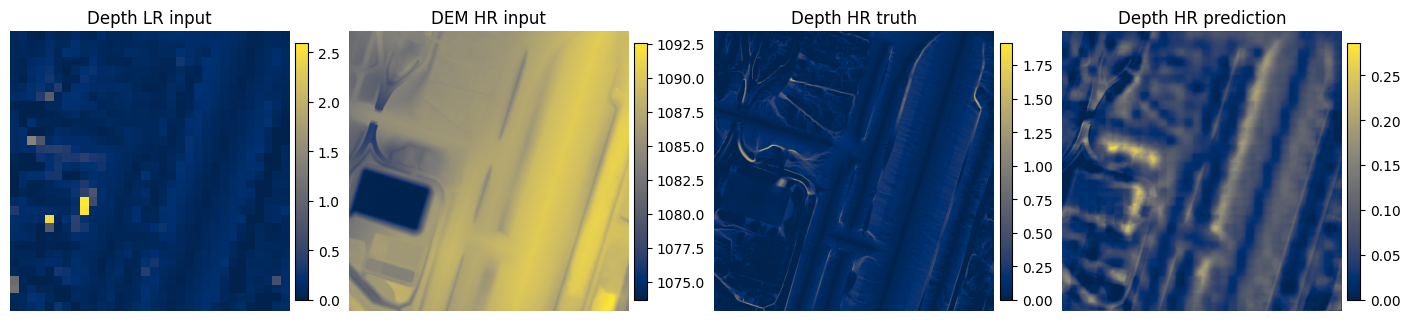

In [13]:
# Show raw inputs and output with minimal plotting code.
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4), constrained_layout=True)

panels = [
    ("Depth LR input", depth_lr_raw),
    ("DEM HR input", dem_hr_raw),
    ("Depth HR truth", depth_hr_true_raw),
    ("Depth HR prediction", depth_hr_pred),
]

for ax, (title, img) in zip(axes, panels):
    im = ax.imshow(img, cmap="cividis")
    ax.set_title(title)
    ax.set_axis_off()
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

plt.show()


## 7) Evaluation-Style Visual Check

In [14]:
# Compute pairwise depth error metrics with the same core definitions as t02.results.
def _compute_depth_error_metrics(
    reference_depth_m: np.ndarray,
    estimate_depth_m: np.ndarray,
    max_depth: float,
    dry_depth_thresh_m: float = 1e-3,
) -> Dict[str, float]:
    """Compute pairwise depth error metrics for one tile."""
    assert reference_depth_m.ndim == 2, f"reference depth must be 2D; got {reference_depth_m.shape}"
    assert estimate_depth_m.shape == reference_depth_m.shape, (
        f"estimate shape {estimate_depth_m.shape} must match reference shape {reference_depth_m.shape}"
    )
    assert max_depth > 0, f"max_depth must be > 0; got {max_depth}"

    reference_np = reference_depth_m.astype(np.float32, copy=False)
    estimate_np = estimate_depth_m.astype(np.float32, copy=False)

    diff = estimate_np - reference_np
    wet_mask = reference_np >= dry_depth_thresh_m
    wet_pixel_count = int(wet_mask.sum())
    total_pixels = int(reference_np.size)
    dry_pixel_count = int(total_pixels - wet_pixel_count)

    mse_all = float(np.mean(np.square(diff), dtype=np.float64))
    rmse_all = float(np.sqrt(mse_all))
    mae_all = float(np.mean(np.abs(diff), dtype=np.float64))
    bias_all = float(np.mean(diff, dtype=np.float64))

    if wet_pixel_count > 0:
        rmse_wet = float(np.sqrt(np.mean(np.square(diff[wet_mask]), dtype=np.float64)))
    else:
        rmse_wet = np.nan

    if mse_all <= 0.0:
        psnr = np.inf
    else:
        psnr = float(20.0 * np.log10(max_depth) - 10.0 * np.log10(mse_all))

    ref64 = reference_np.astype(np.float64, copy=False)
    est64 = estimate_np.astype(np.float64, copy=False)
    mu_x = float(ref64.mean())
    mu_y = float(est64.mean())
    sigma_x = float(ref64.var())
    sigma_y = float(est64.var())
    sigma_xy = float(((ref64 - mu_x) * (est64 - mu_y)).mean())

    c1 = float((0.01 * max_depth) ** 2)
    c2 = float((0.03 * max_depth) ** 2)
    ssim_num = (2.0 * mu_x * mu_y + c1) * (2.0 * sigma_xy + c2)
    ssim_den = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x + sigma_y + c2)
    ssim = float(ssim_num / ssim_den) if ssim_den != 0.0 else np.nan

    return {
        "psnr": psnr,
        "ssim": ssim,
        "mae_m": mae_all,
        "rmse_m": rmse_all,
        "rmse_wet_m": rmse_wet,
        "bias_m": bias_all,
        "wet_pixel_count": wet_pixel_count,
        "dry_pixel_count": dry_pixel_count,
    }


# Resize depth rasters deterministically without TensorFlow.
def _resize_depth_with_pillow(
    depth_m: np.ndarray,
    target_hw: Tuple[int, int],
    resample,
) -> np.ndarray:
    """Resize a 2D depth raster to target HW using Pillow float mode."""
    assert depth_m.ndim == 2, f"depth must be 2D; got {depth_m.shape}"
    target_h, target_w = int(target_hw[0]), int(target_hw[1])
    assert target_h > 0 and target_w > 0, f"invalid resize target {target_hw}"

    pil_depth = Image.fromarray(depth_m.astype(np.float32), mode="F")
    resized = pil_depth.resize((target_w, target_h), resample=resample)
    return np.asarray(resized, dtype=np.float32)


# Compute LR baseline, bilinear baseline, and SR metrics to match plot_chip_comparison rows.
def _compute_depth_tile_metrics(
    lowres_depth_m: np.ndarray,
    highres_depth_m: np.ndarray,
    pred_depth_m: np.ndarray,
    max_depth: float,
    dry_depth_thresh_m: float = 1e-3,
):
    """Compute lr/bl/sr metrics for one chip and return comparison rasters."""
    assert lowres_depth_m.ndim == 2, f"lowres depth must be 2D; got {lowres_depth_m.shape}"
    assert highres_depth_m.ndim == 2, f"highres depth must be 2D; got {highres_depth_m.shape}"
    assert pred_depth_m.shape == highres_depth_m.shape, (
        f"prediction shape {pred_depth_m.shape} must match target shape {highres_depth_m.shape}"
    )

    target_hw = (int(highres_depth_m.shape[0]), int(highres_depth_m.shape[1]))
    resampling = getattr(Image, "Resampling", Image)

    lr_img = _resize_depth_with_pillow(lowres_depth_m, target_hw, resample=resampling.NEAREST)
    bl_img = _resize_depth_with_pillow(lowres_depth_m, target_hw, resample=resampling.BILINEAR)

    metrics = {}
    for prefix, estimate in (("lr", lr_img), ("bl", bl_img), ("sr", pred_depth_m)):
        metric_group = _compute_depth_error_metrics(
            reference_depth_m=highres_depth_m,
            estimate_depth_m=estimate,
            max_depth=max_depth,
            dry_depth_thresh_m=dry_depth_thresh_m,
        )
        for key, value in metric_group.items():
            metrics[f"{prefix}_{key}"] = value

    return metrics, lr_img, bl_img


# Format scalar metrics for compact histogram annotations.
def _fmt_metric(value: float, ndigits: int = 4) -> str:
    """Return fixed-width metric text with NaN handling."""
    if value is None or not np.isfinite(value):
        return "nan"
    return f"{value:.{ndigits}f}"


# Render the evaluation panel with the same 4-row structure as plot_chip_comparison.
def _plot_chip_comparison_like(
    highres_depth_m: np.ndarray,
    lowres_depth_m: np.ndarray,
    pred_depth_m: np.ndarray,
    max_depth: float,
    dry_depth_thresh_m: float = 1e-3,
    cmap: str = "cividis",
    vmax: float = 1.0,
    model_label: str = "ONNX",
):
    """Render comparison histograms and rasters in results.py style."""
    metrics, lr_img, bl_img = _compute_depth_tile_metrics(
        lowres_depth_m=lowres_depth_m,
        highres_depth_m=highres_depth_m,
        pred_depth_m=pred_depth_m,
        max_depth=max_depth,
        dry_depth_thresh_m=dry_depth_thresh_m,
    )

    rows = [
        ("High resolution", highres_depth_m, None),
        ("Low resolution", lr_img, "lr"),
        ("Bilinear upsample", bl_img, "bl"),
        (f"SR ({model_label})", pred_depth_m, "sr"),
    ]

    fig, axes = plt.subplots(nrows=4, ncols=2, sharex="col", figsize=(10, 12))

    for row_idx, (title, img, metric_prefix) in enumerate(rows):
        ax_hist = axes[row_idx, 0]
        ax_img = axes[row_idx, 1]

        masked = np.ma.masked_array(img, mask=img < dry_depth_thresh_m)
        values = masked.compressed()

        ax_hist.hist(values, bins=50, density=True)
        ax_hist.axvline(dry_depth_thresh_m, color="red", linestyle="--", linewidth=1.2)
        ax_hist.set_ylabel("Density")
        ax_hist.set_xlim(0.0, max_depth)
        if row_idx == len(rows) - 1:
            ax_hist.set_xlabel("Depth (m)")

        info_lines = []
        if metric_prefix is not None:
            info_lines.extend(
                [
                    f"PSNR={_fmt_metric(metrics[f'{metric_prefix}_psnr'], 2)} dB",
                    f"SSIM={_fmt_metric(metrics[f'{metric_prefix}_ssim'])}",
                    f"MAE={_fmt_metric(metrics[f'{metric_prefix}_mae_m'])} m",
                    f"RMSE={_fmt_metric(metrics[f'{metric_prefix}_rmse_m'])} m",
                    f"RMSE_wet={_fmt_metric(metrics[f'{metric_prefix}_rmse_wet_m'])} m",
                    f"Bias={_fmt_metric(metrics[f'{metric_prefix}_bias_m'])} m",
                ]
            )
        info_lines.append(_stats_text(values))
        ax_hist.text(0.98, 0.98, "\n".join(info_lines), ha="right", va="top", transform=ax_hist.transAxes)

        im = ax_img.imshow(masked, cmap=cmap, vmin=0.0, vmax=vmax)
        ax_img.set_title(title)
        ax_img.set_axis_off()

        cbar = fig.colorbar(im, ax=ax_img, orientation="vertical", fraction=0.04, pad=0.02, shrink=0.82)
        cbar.ax.tick_params(labelsize=8)

    fig.tight_layout()
    return fig, metrics



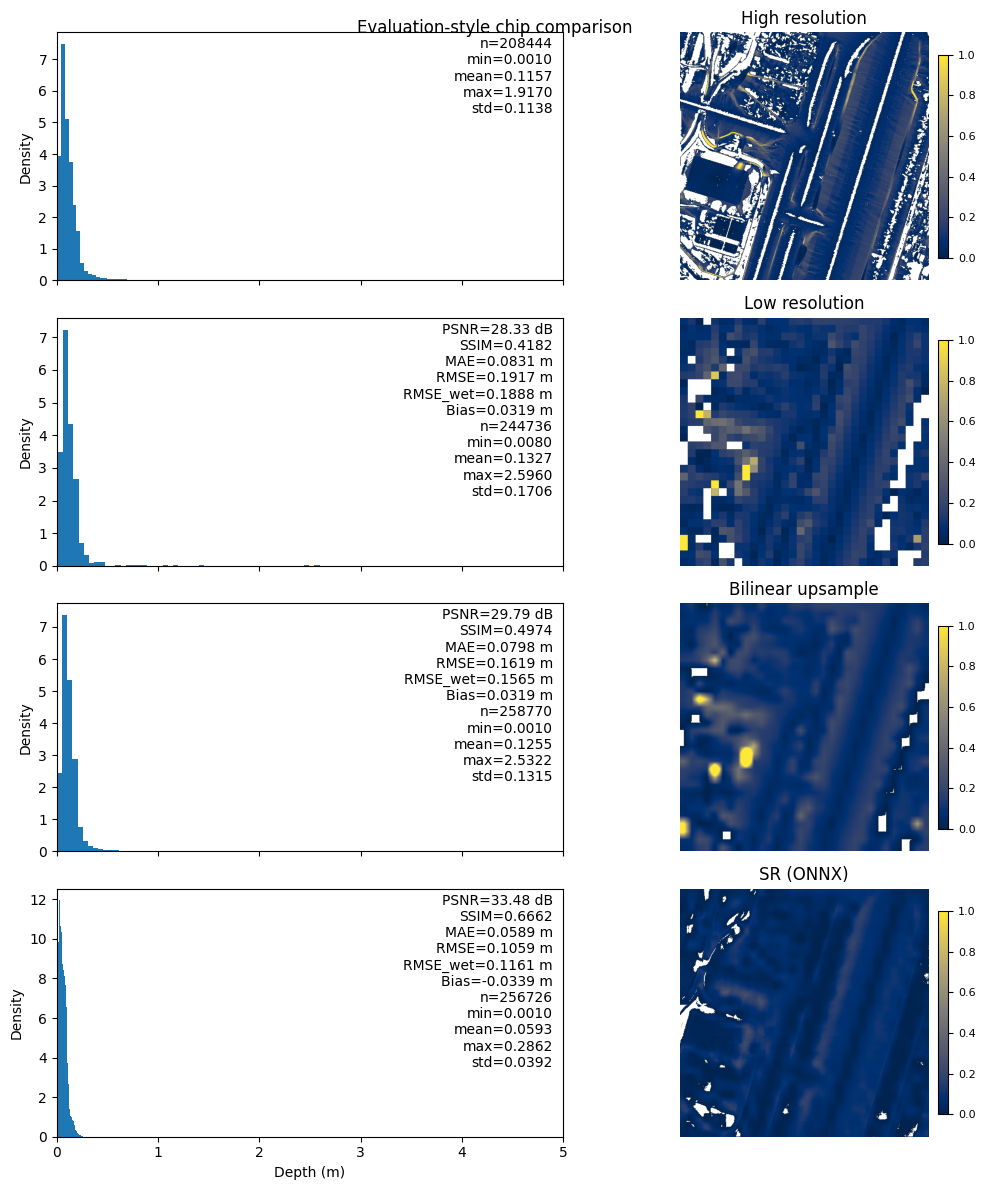

lr_mae_m: 0.083120
bl_mae_m: 0.079842
sr_mae_m: 0.058874
lr_rmse_m: 0.191664
bl_rmse_m: 0.161934
sr_rmse_m: 0.105933
lr_ssim: 0.418216
bl_ssim: 0.497398
sr_ssim: 0.666199


In [15]:
# Generate the evaluation-style panel and print key SR/BL metrics.
dry_depth_thresh_m = 1e-3
fig_eval, eval_metrics = _plot_chip_comparison_like(
    highres_depth_m=depth_hr_true_raw,
    lowres_depth_m=depth_lr_raw,
    pred_depth_m=depth_hr_pred,
    max_depth=max_depth,
    dry_depth_thresh_m=dry_depth_thresh_m,
    cmap="cividis",
    vmax=1.0,
    model_label="ONNX",
)
fig_eval.suptitle("Evaluation-style chip comparison", fontsize=12)
plt.show()

for metric_key in [
    "lr_mae_m",
    "bl_mae_m",
    "sr_mae_m",
    "lr_rmse_m",
    "bl_rmse_m",
    "sr_rmse_m",
    "lr_ssim",
    "bl_ssim",
    "sr_ssim",
]:
    print(f"{metric_key}: {eval_metrics[metric_key]:.6f}")
